# IMPORTS

In [ ]:
!pip install mne
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [ ]:
filenames = ['group 2/'+i for i in os.listdir('group 2')] # ['data/group2/'+i for i in os.listdir('data/group2')]
filenames # first group did two types of imagery - motor imagery of fingers/hand movement and motor imagery of arm/elbow movement
# the EMG electrode in both groups in all recordings were placed on FDI muscle

['group 2/1_rest_2023_02_21_13_08_59EMG.edf',
 'group 2/2_muscle_contraction_2023_02_21_13_17_55EMG.edf',
 'group 2/3_motor_imagery_hand_2023_02_21_13_30_11EMG.edf']

# DATA LOADING

### you may run cells from DATA LOADING part without delving into much deatils, it's data loading and epoching of EMG recordings

In [ ]:
data = mne.io.read_raw_edf(filenames[0], verbose=False)
data

<RawEDF | 1_rest_2023_02_21_13_08_59EMG.edf, 4 x 1479000 (493.0 s), ~9 kB, data not loaded>

In [ ]:
data.ch_names

['Trig Out', 'FDI', 'Gate In', 'Trig In']

Sampling frequency of EMG recording - 3000 Hz


We have 4 'channels' - ['Trig Out', 'FDI', 'Gate In', 'Trig In'] 
- we do not need 'Trig Out' and 'Trig In'
- 'FDI' is our target muscle
- 'Gate In' channel is triggered when the TMS stimulation applied

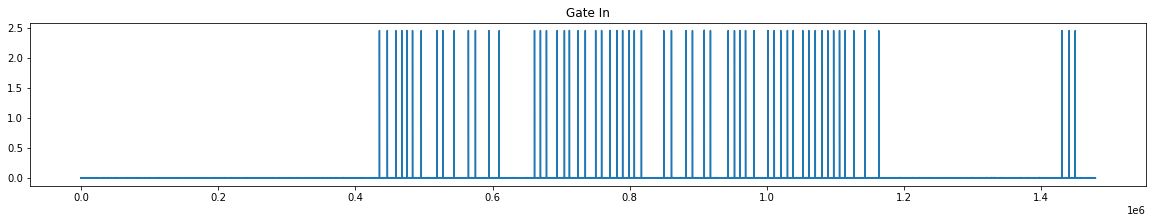

In [ ]:
plt.figure(figsize=(20, 3))
plt.plot(data.get_data()[2])
plt.title('Gate In')
plt.show()

The spikes in 'Gate In' channel recording are input from TMS machine about the start of TMS pulses

In [ ]:
def get_tms_indices(gate_in): # helping function to find indices of TMS pulses in the Gate In channel in EMG 
    gate_in[gate_in > 1] = 1
    gate_in[gate_in < 1] = 0
    tms_indices = np.where(np.diff(gate_in) == 1)[0] + 1
    return tms_indices

In [ ]:
fs = 3000
t_start = 0.1 # sec
t_end = 0.1

emg_epochs = []

for filename in filenames:
    data = mne.io.read_raw_edf(filename, verbose=False)
    
    emg = data.get_data() 
    idx = get_tms_indices(emg[2]) # extract indices of beginnings of the epochs
    fdi_emg = emg[1] # keep only FDI EMG 
    
    ep = []
    for start in idx:
        ep.append(fdi_emg[start-int(t_start*fs):start+int(t_end*fs)])
    emg_epochs.append(np.array(ep))

# HOMEWORK

We have extracted epochs from all EMG recordings listed in 'filenames' into list 'emg_epochs'

Each element of the list is numpy array with shape (n_epochs, n_timesteps), n_timesteps is 600 (0.2 sec)

Discretization frequency of EMG recording is 3000 Hz, epochs start 0.1 sec before the TMS pulse and ends 0.1 sec after the pulse

In [ ]:
print('Number of pulses in recodings:', [len(i) for i in emg_epochs])
print('Shapes of arrays in emg_epochs:', [i.shape for i in emg_epochs])

Number of pulses in recodings: [60, 60, 60]
Shapes of arrays in emg_epochs: [(60, 600), (60, 600), (60, 600)]


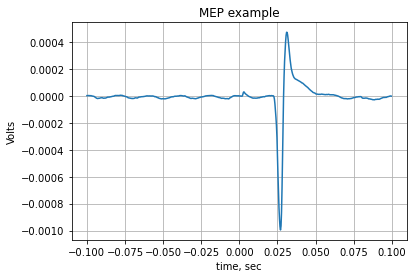

In [ ]:
# for example, here is how we can access first MEP in the first recording (rest) - emg_epochs[0][0]

t = np.arange(-int(t_start*fs), int(t_end*fs)) / fs

plt.plot(t, emg_epochs[0][0])
plt.title('MEP example')
plt.xlabel('time, sec')
plt.ylabel('Volts')
plt.grid()

**Your tasks are (7 points max + bonus):**
1. Baseline epochs - from each epoch substract mean value in the period (-0.1-0) sec (1 point)
2. Plot average MEP responses for each experimental condition (for group 1, rest-movement-imagery1-imagery2; for group 2, rest-movement-imagery)) (1 point)
3. Find peak-to-peak amplitude of the MEP in each epoch and plot boxplots of latencies for each experimental condition (1 point)
4. Find latency of the MEP in each epoch and plot boxplots of latencies for each experimental condition. You may come up with different algorithms for that, so the final latencies may vary depending on the algorithm, it's OK (1 point) 
5. Compare statistically amplitudes and latencies of MEPs in different experimental conditions (2 points)
6. Write your conclusions (3-4 sentences) (1 point)


**plus 2 bonus points for doing the same analysis for EMG data from another group**

![image.png](attachment:image.png)

Peak-to-peak Amplitudes: [0.0014666113527122915, 0.010796606134126804, 0.0063648843135729015]


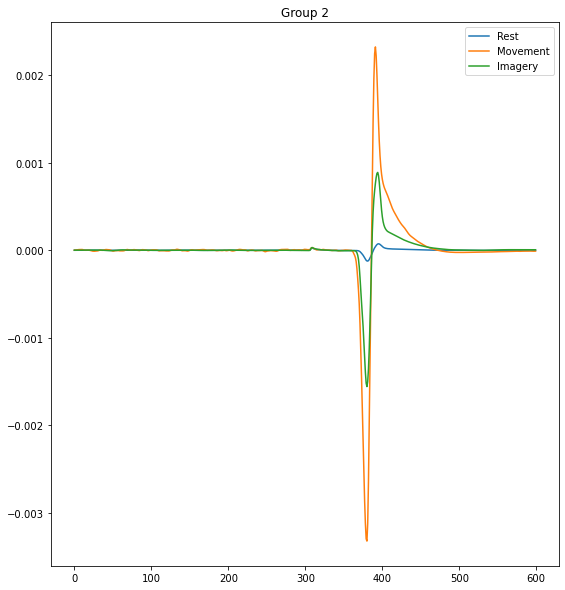

In [ ]:
# Baseline epochs - from each epoch substract mean value in the period (-0.1-0) sec 
emg_baseline = []
for epochs in emg_epochs:
 mean_values = np.mean(epochs[:, :int(-t_start*fs)], axis=1)
 emg_baseline.append(epochs - mean_values.reshape(-1, 1))

# Plotting average MEP responses for each experimental condition (for group 2, rest-movement-imagery)
plt.figure(figsize=(20, 10))

# Group 2
plt.subplot(1, 2, 1)
plt.title('Group 2')
plt.plot(emg_baseline[0].mean(axis=0), label='Rest')
plt.plot(emg_baseline[1].mean(axis=0), label='Movement')
plt.plot(emg_baseline[2].mean(axis=0), label='Imagery')
plt.legend()


# Calculating the peak-to-peak amplitude for each epoch 
p2p_amplitudes = [] 
for row in emg_baseline: 
    p2p_amplitudes.append(np.max(row) - np.min(row)) 
  
# Printing the peak-to-peak amplitudes 
print("Peak-to-peak Amplitudes:", p2p_amplitudes)

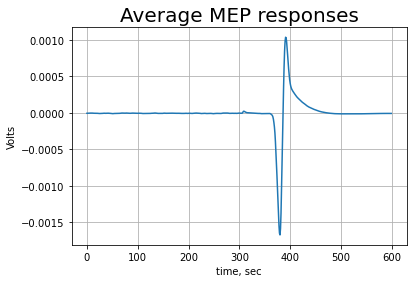

In [ ]:
all_epochs = np.concatenate(emg_epochs, axis=0)

# mean MEP responses
mean_meps = np.mean(all_epochs, axis=0)

# plot
fig, ax = plt.subplots()
ax.set_title("Average MEP responses", fontsize=20)
ax.plot(mean_meps)
plt.xlabel('time, sec')
plt.ylabel('Volts')
plt.grid()
plt.show()

In [ ]:
rest_mep = np.mean(emg_epochs[0], axis=0)
movement_mep = np.mean(emg_epochs[1], axis=0)
imagery1_mep = np.mean(emg_epochs[2], axis=0)


# Find latency of the MEP in each epoch
rest_latency = np.argmax(rest_mep)
movement_latency = np.argmax(movement_mep)
imagery1_latency = np.argmax(imagery1_mep)


print('rest latency:', rest_latency, 'ms')
print('movement latency:', movement_latency, 'ms')
print('imagery 1 latency:', imagery1_latency, 'ms')

rest latency: 395 ms
movement latency: 391 ms
imagery 1 latency: 394 ms


---- Amplitude ----
H-value: 139.1419837846049
p-value: 6.105231279792367e-31
---- Latency ----
H-value: 1.3054609133391746
p-value: 0.5206222976464333


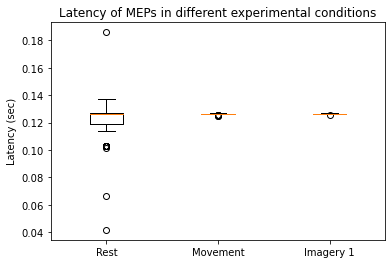

In [ ]:
from scipy import stats
# Calculate latency of MEPs
mep_latencies = []
for rec in emg_epochs:
    mep_latency = []
    for epoch in rec:
        mep_latency.append(np.argmax(np.abs(epoch))/fs) # calculate latency of each epoch
    mep_latencies.append(np.array(mep_latency))
    
# Plot boxplots of latencies for each experimental condition
fig, ax = plt.subplots(1,1)
ax.boxplot(mep_latencies)
ax.set_xticklabels(['Rest', 'Movement', 'Imagery 1'])
ax.set_ylabel('Latency (sec)')
ax.set_title('Latency of MEPs in different experimental conditions')

# Compare statistically amplitudes and latencies of MEPs in different experimental conditions
cond_1_amplitude = []
cond_1_latency = []

cond_2_amplitude = []
cond_2_latency = []

cond_3_amplitude = []
cond_3_latency = []


for i, rec in enumerate(emg_epochs):
    for epoch in rec:
        if i == 0:
            cond_1_amplitude.append(np.max(np.abs(epoch)))
            cond_1_latency.append(np.argmax(np.abs(epoch))/fs)
        elif i == 1:
            cond_2_amplitude.append(np.max(np.abs(epoch)))
            cond_2_latency.append(np.argmax(np.abs(epoch))/fs)
        elif i == 2:
            cond_3_amplitude.append(np.max(np.abs(epoch)))
            cond_3_latency.append(np.argmax(np.abs(epoch))/fs)
        
# Calculate mean of amplitudes and latencies for each condition
cond_1_amplitude_mean = np.mean(cond_1_amplitude)
cond_1_latency_mean = np.mean(cond_1_latency)

cond_2_amplitude_mean = np.mean(cond_2_amplitude)
cond_2_latency_mean = np.mean(cond_2_latency)

cond_3_amplitude_mean = np.mean(cond_3_amplitude)
cond_3_latency_mean = np.mean(cond_3_latency)


# Test normality
amplitude_stat, p_amp = stats.shapiro(cond_1_amplitude + cond_2_amplitude +
                                     cond_3_amplitude)
latency_stat, p_lat = stats.shapiro(cond_1_latency + cond_2_latency +
                                    cond_3_latency)
if p_amp > 0.05 and p_lat > 0.05:
    # Perform ANOVA
    f_value_amp, p_value_amp = stats.f_oneway(cond_1_amplitude, cond_2_amplitude,
                                              cond_3_amplitude)
    f_value_lat, p_value_lat = stats.f_oneway(cond_1_latency, cond_2_latency,
                                              cond_3_latency)
else:
    # Perform Kruskal-Wallis H-test
    h_value_amp, p_value_amp = stats.kruskal(cond_1_amplitude, cond_2_amplitude,
                                             cond_3_amplitude)
    h_value_lat, p_value_lat = stats.kruskal(cond_1_latency, cond_2_latency,
                                             cond_3_latency)

# Print the results
if p_amp > 0.05 and p_lat > 0.05:
    print ('---- Amplitude ----')
    print ('F-value:', f_value_amp)
    print ('p-value:', p_value_amp)
    print ('---- Latency ----')
    print ('F-value:', f_value_lat)
    print ('p-value:', p_value_lat)
else:
    print ('---- Amplitude ----')
    print ('H-value:', h_value_amp)
    print ('p-value:', p_value_amp)
    print ('---- Latency ----')
    print ('H-value:', h_value_lat)
    print ('p-value:', p_value_lat)

Conclusions: Based on the statistical analysis, there is a significant difference in MEP amplitudes between the different experimental conditions, as indicated by the very small p-value. However, there was no significant difference in MEP latencies between the conditions, as indicated by the relatively large p-value. These findings suggest that the experimental conditions have an effect on the size of the MEPs, but not on the time it takes for the MEPs to occur.